In [1]:
EXP_NAME = "EXP_2_1"

In [2]:
import torch; torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from function.Dir import Dir
from function.Dataset import ImageDataset
from function.Loss import Custom_criterion
from function.Log import log
import importlib

VAE_module = importlib.import_module(f'function.VAE_{EXP_NAME}')
VAE = getattr(VAE_module, 'VAE')

NUM_TO_LEARN = 5000 #训练集放入图片对数量
EPOCHS = 1000 #参数1
BATCH_SIZE = 128 #参数2
LATENTDIM = 256 #参数3
LR_MAX = 5e-4
LR_MIN = 5e-6
mode = 1 #0代表STED_HC文件训练，1代表使用STED，对应ImageDataset里的 mode 参数。（STED出的模型对泛化能力弱，STED_HC对训练集的还原会有点失真）

DEVICE = 'cuda'
LOSS_PLOT = []
EPOCH_PLOT = []

In [3]:
name = f'{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn'

#加载数据集
dataset = ImageDataset(NUM_TO_LEARN, mode)
dataloader = DataLoader(dataset, BATCH_SIZE, True)

#初始化VAE网络
vae = VAE(LATENTDIM).to(DEVICE)
vae = nn.DataParallel(vae) #将 VAE 包装成一个并行化模型，以便在多个 GPU 上并行地进行训练

#定义LOSS函数与优化器
criterion1 = nn.MSELoss()
criterion2 = Custom_criterion().cuda()
optimizer = torch.optim.AdamW(vae.parameters(), lr = LR_MAX)

In [4]:
def train(dataloader, num_epochs):
    with open(f'training.log', 'w') as nothing: # 清空原log
        pass
    log(f"Experiment name: {EXP_NAME}")
    for epoch in range(num_epochs):
        vae.train() # 切换成训练模式
        total_loss = 0.0
        current_lr = LR_MIN + 0.5 * (LR_MAX - LR_MIN) * (1 + np.cos(np.pi * epoch / EPOCHS))
        optimizer = torch.optim.AdamW(vae.parameters(), lr = current_lr)

        for _, (img_LR, img_HR) in enumerate(dataloader):
            img_LR = torch.squeeze(img_LR,dim = 1).to(DEVICE)
            img_HR = torch.squeeze(img_HR,dim = 1).to(DEVICE)
            img_SR, _, _ = vae(img_LR)
            img_SR = img_SR.to(DEVICE)
            # 这步为止，img_LR,img_HR,img_SR均是[batchsize,不知道是什么,宽，高]
            if epoch <= 500:
                loss = criterion1(img_SR, img_HR)
            if epoch > 500:
                loss = criterion2(img_SR, img_HR) # 每个BATCH的loss，64张图平均
            optimizer.zero_grad()
            loss.backward() # 最耗算力的一步
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader) # 每个EPOCH的loss，全部数据集的平均
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}, Current_LR:{current_lr:.4f}")
        log(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}, Current_LR:{current_lr:.4f}")

        LOSS_PLOT.append(total_loss)
        EPOCH_PLOT.append(epoch)
        if epoch % 300 == 0:
            torch.save(vae.state_dict(), Dir.TEMP()+'/checkpoint.pth')

In [5]:
print(f'DEVICE:{DEVICE}\n')
print(f'Training Start. \nExperiment name: {EXP_NAME}')
train(dataloader, EPOCHS)
print(f'\n Succsessfully done! Training log saved.')

DEVICE:cuda

Training Start. 
Experiment name: EXP_2_1
Epoch [1/100], Average Loss: 0.182842, Current_LR:0.0005
Epoch [2/100], Average Loss: 0.182137, Current_LR:0.0005
Epoch [3/100], Average Loss: 0.181418, Current_LR:0.0005
Epoch [4/100], Average Loss: 0.180517, Current_LR:0.0005
Epoch [5/100], Average Loss: 0.179257, Current_LR:0.0005
Epoch [6/100], Average Loss: 0.177408, Current_LR:0.0005
Epoch [7/100], Average Loss: 0.177161, Current_LR:0.0005
Epoch [8/100], Average Loss: 0.176483, Current_LR:0.0005
Epoch [9/100], Average Loss: 0.175227, Current_LR:0.0005
Epoch [10/100], Average Loss: 0.175270, Current_LR:0.0005
Epoch [11/100], Average Loss: 0.173060, Current_LR:0.0005
Epoch [12/100], Average Loss: 0.173652, Current_LR:0.0005
Epoch [13/100], Average Loss: 0.171092, Current_LR:0.0005
Epoch [14/100], Average Loss: 0.172087, Current_LR:0.0005
Epoch [15/100], Average Loss: 0.169084, Current_LR:0.0005
Epoch [16/100], Average Loss: 0.170769, Current_LR:0.0005
Epoch [17/100], Average Lo

LOSS fig saved at ../outputs/trained_models/EXP_2_1_lossfig_100epo_128bth_256latn.png
LOSS data saved at ../outputs/trained_models/EXP_2_1_lossdata_100epo_128bth_256latn.npy
MODEL saved at ../outputs/trained_models/EXP_2_1_model_100epo_128bth_256latn.pth


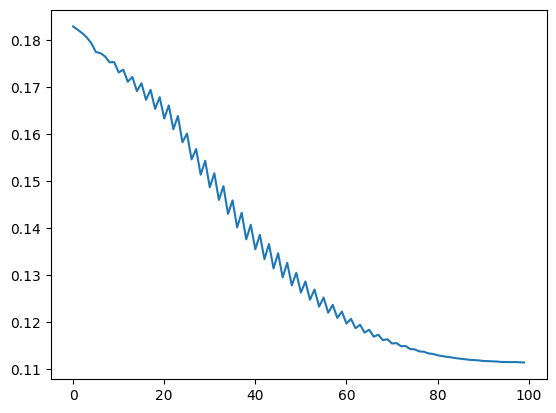

In [6]:
fig,ax = plt.subplots()
ax.plot(EPOCH_PLOT,LOSS_PLOT)
fig.savefig(f'{Dir.models()}/{EXP_NAME}_lossfig_{name}.png', dpi = 300) # 保存LOSS图片
print(f'LOSS fig saved at {Dir.models()}/{EXP_NAME}_lossfig_{name}.png')
LOSS_DATA = np.stack((np.array(EPOCH_PLOT),np.array(LOSS_PLOT)),axis=0)
np.save(f'{Dir.models()}/{EXP_NAME}_lossdata_{name}.npy',LOSS_DATA) # 保存LOSS数据
print(f'LOSS data saved at {Dir.models()}/{EXP_NAME}_lossdata_{name}.npy')
torch.save(vae.state_dict(), f'{Dir.models()}/{EXP_NAME}_model_{name}.pth') #保存模型pth
print(f'MODEL saved at {Dir.models()}/{EXP_NAME}_model_{name}.pth')